# Research Project Midway Point (Healthcare & Technology)

### Adam Walmsley Rowan Murphy

### March 12th, 2025

##### AI Tool Use Declaration:
To write this proposal we did not use ChatGPT or any other form of generative AI


## Project Summary

In this project we are looking at how healthcare spending in Canada changes between provincial government parties and how effective their policies are at having a high quality, functioning healthcare system. Our ultimate goal is to diagnose the success of the various parties in Canada to get an unbiased view of how important the public healthcare system is to each part respectively.

## Research Questions

We have two members in our group and thus two distinct research questions, they are as follows:

1. With what level of importance do the different provincial government parties give to healthcare spending and is there one party that clearly cares more about public healthcare?

2. Which province has the most efficient healthcare spending?

We did not tweak our research questions much since the initial proposal. This is because we felt they were adequate and our TA had no problems whatsoever with them.

## Data Cleaning Steps

The following code and discussion will walk through our data cleaning process for all data sets.

We begin by importing the necessary libraries to enable our data cleaning process.

In [15]:
import pandas as pd
import altair as alt
import numpy as np
import openpyxl
import math
import matplotlib.pyplot as plt

The first data set to tackle is provincial_governments_2000_2024.csv. We made this data set ourselves after compiling historical data for provincial governments in power since 2000. The data set contains data on BC, Alberta, Ontario and Quebec only. We kept the parties specific names in, and there exist the following distinct parties in the dataset:

- NDP
- BC Liberal Party
- Progressive Conservative Party
- United Conservative Party
- Liberal Party
- Parti Quebecois
- Coalition Avenir Quebec

After researching the similarities between similarily named parties we realized some should be combined into one specific naming convention. Specifically, we will combine: 
- BC Liberal Party and Liberal Party into just Liberal Party
- Progressive Conservative Party and United Conservative party into just Conservative Party

Parti Quebecois and Coalition Avenir Quebec are very distinct in their policies and these will be kept separate as they are. Also, we will remove the accents above the e's in the Quebec party names. To perform this cleaning we present the following code.

In [16]:
# Load in data
prov_df = pd.read_csv('Data/provincial_governments_2000_2024.csv')

# Select columns to change
columns_to_modify = [
    'BC Provincial Government',
    'Alberta Provincial Government',
    'Ontario Provincial Government',
    'Quebec Provincial Government'
]

# Identify specific replacements
replacements = {
    'BC Liberal Party': 'Liberal Party',
    'Progressive Conservative Party': 'Conservative Party',
    'United Conservative Party': 'Conservative Party',
    'Parti Québécois': 'Parti Quebecois',
    'Coalition Avenir Québec': 'Coalition Avenir Quebec'
}

# Apply changes
prov_df[columns_to_modify] = prov_df[columns_to_modify].replace(replacements)

Next, for compatibility we need to reorganize the layout of this dataset to be (Province, year, Government). We implement this with the following code.

In [17]:
# Pivot the dataframe to suggested format
df_long = pd.melt(prov_df, 
                  id_vars=['Year'], 
                  var_name='Province', 
                  value_name='Government')

# Clean up column names
df_long['Province'] = df_long['Province'].str.replace(' Provincial Government', '')

# Write to csv
df_long.to_csv('Data/Clean/provincial_governments_2000_2024.csv', index=False)

# Display cleaned and formatted data
df_long.head(3)

,Year,Province,Government
0,2000,BC,NDP
1,2001,BC,NDP
2,2002,BC,Liberal Party


Next we look to clean the data set regarding provincial health expenditure per year percent increase across all provinces. This data set is particularly messy to begin with. We will perform the following operations to make the data suit our needs:

- Remove rows 1 to 56 since they contain data only on total expenditure whereas we want percent increase/decrease in expenditure which is found on rows 56 and below
- Remove rows past 105 since they contain other data we are not interested in
- Remove columns which concern provinces we are not interested in
- Remove rows from years outside of 2000 to 2024
- Correct data types for all data since initial spreadsheet has all strings
- Rename columns for better formatting

In [18]:
# Load in data
prov_spending_df = pd.read_csv('Data/nhex_prov_terr_data.csv', skiprows = 56, nrows = 49)

# Select columns we care about
columns_of_interest = [
    "Year", 
    "B.C.     ",
    "Alta.    ",
    "Ont.",
    "Que.  " 
]

# Drop columns be do not care about
prov_spending_df = prov_spending_df[columns_of_interest]

# Convert data to correct types
prov_spending_df["Year"] = prov_spending_df["Year"].astype(int)
other_columns = prov_spending_df.columns.difference(["Year"])
prov_spending_df[other_columns] = prov_spending_df[other_columns].astype(float)

# Drop years we are not concerned with
prov_spending_df = prov_spending_df[(prov_spending_df["Year"] >= 2000)]

prov_spending_df.reset_index(drop=True, inplace=True)

# Rename columns
prov_spending_df.rename(columns={
    "B.C.     ": "BritishColumbia",
    "Alta.    ": "Alberta",
    "Ont.": "Ontario",
    "Que.  ": "Quebec"
}, inplace=True)

Now, to ensure compatibility we reformat this dataset to the structure (province, year, percent_expenditure_change), we do this with the following code.

In [19]:
# Pivot
df_long_spending = pd.melt(prov_spending_df,
                  id_vars=['Year'],
                  var_name='Province',
                  value_name='Percent_expenditure_change')

# Write to csv
df_long_spending.to_csv('Data/Clean/nhex_prov_terr_data.csv', index=False)

# Display the cleaned and formatted data
df_long_spending.head(3)

,Year,Province,Percent_expenditure_change
0,2000,BritishColumbia,9.2
1,2001,BritishColumbia,10.4
2,2002,BritishColumbia,6.4


## Exploratory Data Analysis

In this section we will take a closer look at the trends in our data to gain insight that we can use before further analysis. 

The first thing we will look at is the frequency of each party. To do this we will first plot a histogram of the parties and then a histogram of party by province.

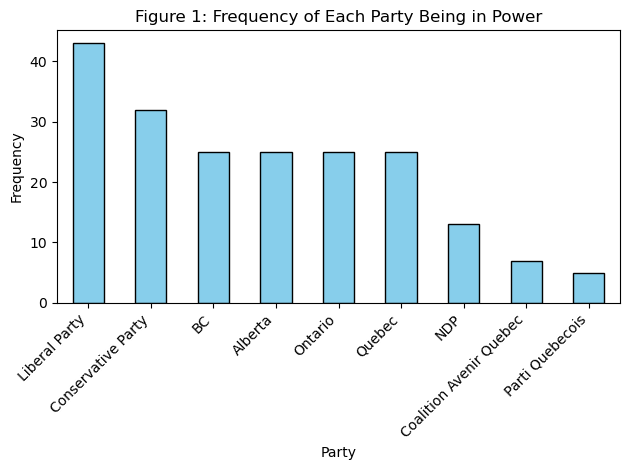

In [5]:
# Load in the clean data of provincial governments in power by year
prov_df = pd.read_csv('Data/Clean/provincial_governments_2000_2024.csv')

# Drop year column
parties_df = prov_df.drop(columns=['Year'])

# Create single list for all occurences of parties
all_parties = parties_df.values.ravel()

# Count occurences of each party
party_counts = pd.Series(all_parties).value_counts()

# Plot frequency of each party being in power
party_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Figure 1: Frequency of Each Party Being in Power')
plt.xlabel('Party')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels for clarity if needed
plt.tight_layout()  # Ensures labels/titles fit nicely
plt.show()

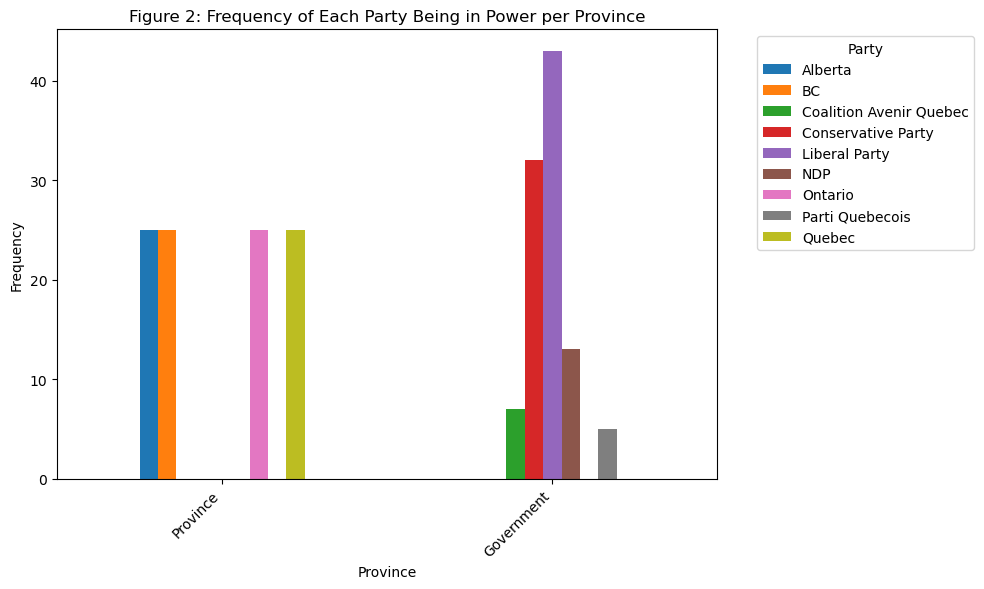

In [6]:
# Identify which columns correspond to provinces (assumes 'Year' is the only non-province column)
province_cols = [col for col in prov_df.columns if col != 'Year']

# Count how often each party appears in each province column
counts_by_province = {}
for col in province_cols:
    counts_by_province[col] = prov_df[col].value_counts()

# Build a DataFrame (rows = parties, columns = provinces)
counts_df = pd.DataFrame(counts_by_province).fillna(0)

# Transpose so provinces are on the x-axis, and each party is a different color bar
counts_df.T.plot(kind='bar', figsize=(10, 6))

# Plot frequency of each party in power per province
plt.title('Figure 2: Frequency of Each Party Being in Power per Province')
plt.xlabel('Province')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside if desired
plt.tight_layout()
plt.show()

From figure 1 we can see the popularity of each party nationwide. Clearly each party has different levels of popularity across Canada, and there is limited data on a few parties, particularly Coalition Avenir Quebec and Parti Quebecois. Figure 2 shows that certain parties are historically much more popular in certain provinces than in others. Liberals are the most popular party historically across three of the four provinces we are interested in, and all provinces but Quebec have only ever had two parties in power. 

## Rowans Stuff

In [7]:

nhex_total = pd.read_csv('https://raw.githubusercontent.com/RibbitsM/368-research-proj/refs/heads/main/Data/nhex_prov_terr_data.csv',
                        header=4, skiprows=lambda x: x > 51, dtype=np.float64, thousands=',', na_values='—')
nhex_percapita = pd.read_csv('https://raw.githubusercontent.com/RibbitsM/368-research-proj/refs/heads/main/Data/nhex_prov_terr_data.csv',
                        header=112, skiprows=lambda x: x > 160, dtype=np.float64, thousands=',', na_values='—')

In [8]:
nhex_total.head()

,Year,N.L.,P.E.I.,N.S.,N.B.,Que.,Ont.,Man.,Sask.,Alta.,B.C.,Y.T.,N.W.T,Nun.,Canada
0,1975.0,199.2,41.5,266.9,203.7,2531.2,3143.5,376.7,302.1,694.9,928.2,6.2,15.2,NaN,8709.3
1,1976.0,219.0,45.4,302.7,242.4,2972.5,3612.5,449.3,364.1,811.6,1082.7,8.8,19.0,NaN,10129.9
2,1977.0,233.5,50.3,334.6,271.7,3269.2,3929.1,497.3,410.8,879.1,1193.1,10.0,23.4,NaN,11102.0
3,1978.0,258.3,56.4,370.0,299.1,3661.8,4229.4,524.9,445.8,1020.5,1363.8,11.4,28.1,NaN,12269.4
4,1979.0,297.3,62.5,413.1,336.7,4088.1,4565.8,569.7,508.5,1258.2,1556.5,12.4,27.9,NaN,13696.6


In [9]:
nhex_percapita.columns = ['Year', 'N.L.', 'P.E.I.', 'N.S.', 'N.B.', 'Que.', 'Ont.', 'Man.', 'Sask.', 'Alta.', 
                        'B.C.', 'Y.T.', 'N.W.T', 'Nun.', 'Canada (Average)']
nhex_percapita.head()

,Year,N.L.,P.E.I.,N.S.,N.B.,Que.,Ont.,Man.,Sask.,Alta.,B.C.,Y.T.,N.W.T,Nun.,Canada (Average)
0,1975.0,357.92,352.59,322.88,300.87,399.86,377.83,367.52,329.31,384.21,371.34,281.70,355.89,NaN,376.32
1,1976.0,389.23,382.68,362.39,351.60,464.68,429.35,435.49,390.82,434.15,427.29,393.11,427.60,NaN,431.98
2,1977.0,412.98,419.50,398.29,390.49,508.18,462.03,479.36,434.85,451.21,464.19,444.82,525.96,NaN,467.93
3,1978.0,455.02,463.22,438.04,427.56,568.57,492.35,504.31,468.12,504.61,521.51,492.42,619.82,NaN,512.01
4,1979.0,521.43,508.78,486.34,478.80,632.25,527.10,549.26,529.79,600.00,583.99,538.34,610.04,NaN,565.94


In [10]:
keep_attributes = ['geogprv','PHC_060','PHC_035','PHC_005','PHC_020','UCN_005']
cchs_data = pd.read_stata("Data\cchs_201920_pumf.dta", columns=keep_attributes,convert_categoricals=False)
cchs_data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\cchs_201920_pumf.dta'

In [ ]:
for name in cchs_data['geogprv'].unique():
    print(name)

In [ ]:
prov_dict = {47:"Sask.",59:'B.C.',13:'N.B.',46:'Man.',35:'Ont.',12:'N.S.',24:'Que.',10:'N.L.', 
            48: 'Alta.', 11: 'P.E.I.', 60: 'Terrs.'}
cchs_data['geogprv'] = cchs_data['geogprv'].replace(prov_dict)

cchs_data_avg = cchs_data.groupby('geogprv',axis=0).mean().round(3).reset_index()
cchs_data_avg

In [ ]:
survey_year_expenditure = nhex_percapita[44:46]
survey_year_expenditure['Terrs'] = ((survey_year_expenditure['Y.T.'] + survey_year_expenditure['N.W.T'] +
                                    survey_year_expenditure['Nun.'])/3)
survey_year_expenditure = survey_year_expenditure.drop(['Year', 'Canada (Average)','Y.T.','N.W.T','Nun.'], axis=1)
nhex_pivot = survey_year_expenditure.melt(var_name='geogprv',value_name='avg_percap_spend'
                                        ).groupby('geogprv').mean().round(3).reset_index()
nhex_pivot

In [ ]:
combined_data = nhex_pivot.merge(cchs_data_avg, on='geogprv')
combined_data.to_csv("cchs+nhex.csv")
combined_data

In [ ]:
PHC_060_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_060').scale(domain=[2,3]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 6500]),
    alt.Color('geogprv'))

PHC_035_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_035').scale(domain=[2.75,4.25]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 6500]),
    alt.Color('geogprv'))

PHC_005_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_005').scale(domain=[1,1.25]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 6500]),
    alt.Color('geogprv'))

PHC_020_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('PHC_020').scale(domain=[1,1.25]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 6500]),
    alt.Color('geogprv'))

UCN_005_chart = alt.Chart(combined_data).mark_circle().encode(
    alt.X('UCN_005').scale(domain=[1.9,2.1]),
    alt.Y('avg_percap_spend').scale(domain=[4000, 6500]),
    alt.Color('geogprv'))

PHC_060_chart & PHC_020_chart | PHC_035_chart & UCN_005_chart | PHC_005_chart 

In [ ]:
def make_sql(input_file, output_file, table_name):
    data = pd.read_csv(input_file)
    with open(output_file, "w") as f:
        f.write("")
    for index, row in data.iterrows():
        with open(output_file, "a") as f:
            f.write("\ninsert into " + table_name + " \nvalues(")
            for item in range(data.shape[1]):
                if item == data.shape[1] - 1:
                    if str(row[item]) == 'nan':
                        f.write("NULL"+');\n')
                    else:
                        f.write("'"+str(row[item])+"'"+');\n')
                else:
                    if str(row[item]) == 'nan':
                        f.write("NULL"+');\n')
                    else:
                        f.write("'"+str(row[item])+"'"+', ')